In [3]:
import networkx as nx
import sys
sys.path.append('..')

import cluster_analysis

### dont touch

In [15]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

clstr_product_path = '../../data/cluster_descriptions/cluster_product.csv'
clstr_product_df=pd.read_csv(clstr_product_path, index_col=0)   

def transform_cluster_to_product(cluster_name):
    #match it ffrom clstr_poduct_df from the index
    cluster = clstr_product_df.loc[cluster_name]
    product=cluster['product_name']
    
    return product

def compute_network_stats(G, network_name="G"):

    if type(G) == str:
        #if its given a gml file path
        G = nx.read_gml(G)

    components = nx.connected_components(G)

    largest_cc = max(components, key=len)
    largest_cc_subgraph = G.subgraph(largest_cc)

    communities = nx.algorithms.community.louvain_communities(G)

    stats = {
        "Name": network_name,
        "|V|": G.number_of_nodes(),
        "|E|": G.number_of_edges(),
        "density": nx.density(G),
        "k": np.mean(list(dict(G.degree()).values())),
        "k weighted": np.mean(list(dict(G.degree(weight='weight')).values())),
        "|components|": nx.number_connected_components(G),
        "cc": nx.average_clustering(G),
        "s_path": nx.average_shortest_path_length(largest_cc_subgraph),
        "d": nx.diameter(largest_cc_subgraph),
        "|communities|": len(list(communities)),
        "Q": nx.community.modularity(G, communities),
        "r_squared": plot_log_log(G, weighted=True, plot=False)
    }

    stats_df = pd.DataFrame(stats, index=[0])
    stats_df.set_index("Name", inplace=True)
    
    return stats_df

def plot_degree_distribution(G, network_name='',weighted=False):
    if not weighted:
        degrees = [G.degree(n) for n in G.nodes()]
        plt.hist(degrees, bins=30,color='lightblue')
        plt.title(network_name)
        plt.show()
    else:
        degrees = [G.degree(n, weight='weight') for n in G.nodes()]
        plt.hist(degrees, bins=30, label=network_name)
        plt.title(network_name)
        plt.show()

def plot_log_log(G, network_name='', weighted=False, plot=True):
    '''
    takes a graph, computes log log degree distribution
    if plot is F, it returns only the r squared of the least squares applied on the log log deg dist

    param:
    -------
        * G: nx.Graph
        * network_name (optional): str, if want to give the plot a title
        * weighted (optional): bool, if  it takes into consideration the weighted degrees instead
        * plot (optional), if want to show a plot ot not
    '''
    if weighted:
        degrees = [G.degree(n, weight='weight') for n in G.nodes()]
    else:
        degrees = [G.degree(n) for n in G.nodes()]

    log_pk = np.log(np.unique(degrees, return_counts=True)[1])
    log_k = np.log(np.unique(degrees, return_counts=True)[0])

    x,y = log_k, log_pk

    ### regression line
    slope, intercept = np.polyfit(x, y, 1)
    # print(f"SLope: {slope*-1}, intercept: {intercept}")
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y)))

    if plot:
        plt.title(f"{network_name}; R sq: {round(r_squared,5)}")
        plt.xlabel("log(k)")
        plt.ylabel("log(p(k))")

        plt.scatter(log_k, log_pk)
        plt.plot(x, slope * x + intercept, color="red")
        plt.show()

    return r_squared

def get_top_n_nodes_centrality(G, centrality_dict, n=10, with_values=False, centrality_name=None):
    sorted_degrees = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(sorted_degrees, columns=["Node", "Centrality"])
    
    if not with_values:
        df = df.drop(columns=["Centrality"])
        if not centrality_name:
            centrality_name = "Centrality"
        df.columns = [f"{centrality_name} nodes"]

    df.index += 1
    df.index.name = "Rank"
    return df[:n]

def get_top_n_nodes(G, n=10, show_product=False, weighted=False):


    if weighted:

        ######################

        #creating positive weights for edges:
        # -- not to lose magnitude, we get teh lowest negative weight, and we add it absolute value to all of the weights, this way it becomes nul

        # weights_sorted=
        # min_weight=
        # abs_min_weight= abs(min_weight)

        # for edge in G.edges(data=True):
        #     edge[2]['positive_weight'] = edge[2]['weight'] + abs_min_weight

        ######################
        

        degrees = dict(G.degree())
        deg_df= get_top_n_nodes_centrality(G, degrees, n=n, centrality_name="Degree")
        degrees = dict(G.degree(weight='positive_weight'))
        deg_df = get_top_n_nodes_centrality(G, degrees, n=n, centrality_name="Weighted Degree")
        betweeness = nx.betweenness_centrality(G, weight='positive_weight')
        betw_df = get_top_n_nodes_centrality(G, betweeness, n=n, centrality_name="Betweenness weighted")
        closeness = nx.closeness_centrality(G, distance='positive_weight')
        close_df = get_top_n_nodes_centrality(G, closeness, n=n, centrality_name="Closeness weighted")
        pagerank = nx.pagerank(G, weight='positive_weight')
        pagerank_df = get_top_n_nodes_centrality(G, pagerank, n=n, centrality_name="PageRank weighted")
        eigenvector = nx.eigenvector_centrality(G, weight='positive_weight')
        eigenvector_df = get_top_n_nodes_centrality(G, eigenvector, n=n, centrality_name="Eigenvector weighted")
        hubs, authorities = nx.hits(G)
        hubs_df = get_top_n_nodes_centrality(G, hubs, n=n, centrality_name="Hubs")
        authorities_df = get_top_n_nodes_centrality(G, authorities, n=n, centrality_name="Authorities")

    else:
        degrees = dict(G.degree())
        deg_df= get_top_n_nodes_centrality(G, degrees, n=n, centrality_name="Degree")
        betweeness = nx.betweenness_centrality(G)
        betw_df = get_top_n_nodes_centrality(G, betweeness, n=n, centrality_name="Betweenness")
        closeness = nx.closeness_centrality(G)
        close_df = get_top_n_nodes_centrality(G, closeness, n=n, centrality_name="Closeness")
        pagerank = nx.pagerank(G)
        pagerank_df = get_top_n_nodes_centrality(G, pagerank, n=n, centrality_name="PageRank")
        eigenvector = nx.eigenvector_centrality(G)
        eigenvector_df = get_top_n_nodes_centrality(G, eigenvector, n=n, centrality_name="Eigenvector")
        hubs, authorities = nx.hits(G)
        hubs_df = get_top_n_nodes_centrality(G, hubs, n=n, centrality_name="Hubs")
        authorities_df = get_top_n_nodes_centrality(G, authorities, n=n, centrality_name="Authorities")

    #concatenate all at the same index
    all_df = pd.concat([deg_df, betw_df, close_df, eigenvector_df, pagerank_df, hubs_df, authorities_df], axis=1)

    if show_product:
        # - transforming all entries to prooduct names
        for col in all_df.columns:
            all_df[col] = all_df[col].apply(lambda x: transform_cluster_to_product(x))

    return all_df



### run

In [6]:
G= nx.read_graphml('../../data/graphs-2/unsigned_correlation_network_0.6.graphml')

G = cluster_analysis.set_cluster_attributes(G, '../../pangenome-repo/Pangenome-Analysis-Workflow/codes/Campylobacter_coli')
nx.write_graphml(G,'../../data/WGCN/TRIAL1_unsigned_correlation_network_0.6.graphml')

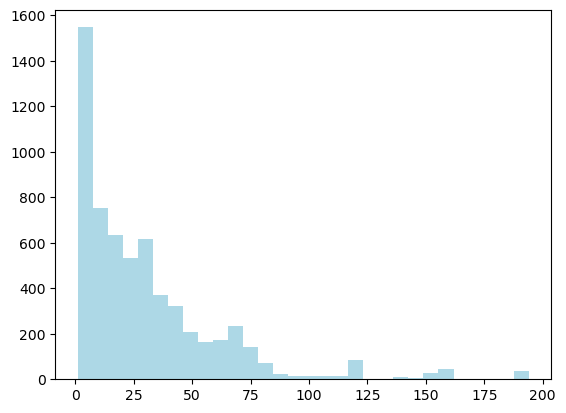

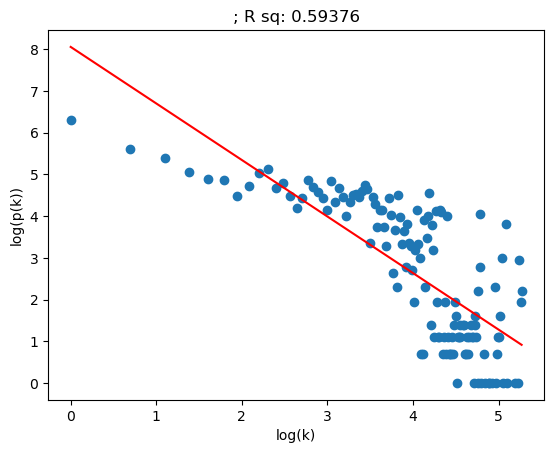

0.5937615374092897

In [11]:
import network_analysis

network_analysis.plot_degree_distribution(G, '')
network_analysis.plot_log_log(G, '')

In [16]:
get_top_n_nodes(G, 10, show_product=True)

,Degree nodes,Betweenness nodes,Closeness nodes,Eigenvector nodes,PageRank nodes,Hubs nodes,Authorities nodes
Rank,,,,,,,
1,hypothetical protein,"Formate dehydrogenase-O, major subunit (EC 1.2...",hypothetical protein,hypothetical protein,hypothetical protein,hypothetical protein,Short-chain dehydrogenase/reductase SDR
2,hypothetical protein,"Type I restriction-modification system, specif...",hypothetical protein,hypothetical protein,"D-glycero-beta-D-manno-heptose-1,7-bisphosphat...",hypothetical protein,TrsK-like protein
3,hypothetical protein,RloF,Integral membrane protein,hypothetical protein,hypothetical protein,hypothetical protein,hypothetical protein
4,hypothetical protein,hypothetical protein,hypothetical protein,TrsK-like protein,"D-glycero-beta-D-manno-heptose-1,7-bisphosphat...",TrsK-like protein,hypothetical protein
5,hypothetical protein,Phosphoglycerol transferase-like protein,hypothetical protein,Membrane protein,hypothetical protein,Membrane protein,IncQ plasmid conjugative transfer protein TraG
6,hypothetical protein,GTP-binding protein Obg,hypothetical protein,TnpY-like protein,"McrBC restriction endonuclease system, McrB su...",TnpY-like protein,Conjugative transfer protein TrbL
7,hypothetical protein,Channel-forming transporter/cytolysins activat...,hypothetical protein,hypothetical protein,hypothetical protein,hypothetical protein,hypothetical protein
8,hypothetical protein,hypothetical protein,"Fe2+ ABC transporter, substrate binding protein",hypothetical protein,Motility accessory factor,hypothetical protein,hypothetical protein
9,hypothetical protein,Dicarboxylate carrier protein,hypothetical protein,mobilization/transfer protein,hypothetical protein,mobilization/transfer protein,hypothetical protein


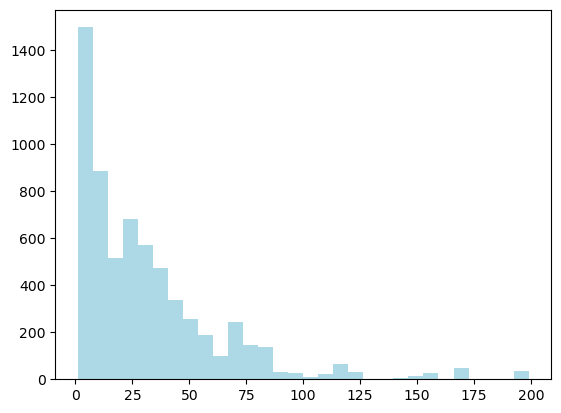

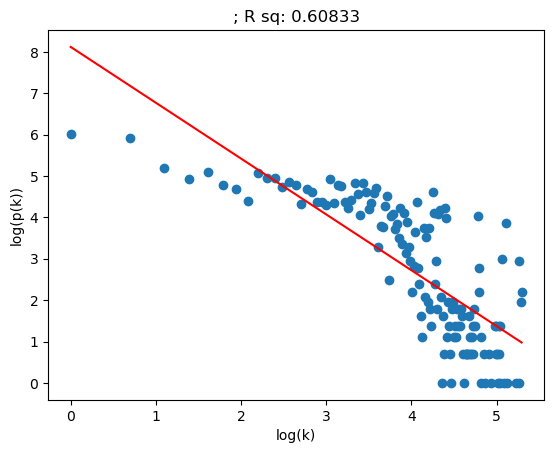

0.6083349408375803

In [17]:
G1= nx.read_graphml('../../data/graphs-2/signed_correlation_network_0.6.graphml')

G1 = cluster_analysis.set_cluster_attributes(G1, '../../pangenome-repo/Pangenome-Analysis-Workflow/codes/Campylobacter_coli')
nx.write_graphml(G1,'../../data/WGCN/TRIAL1_signed_correlation_network_0.6.graphml')

network_analysis.plot_degree_distribution(G1, '')
network_analysis.plot_log_log(G1, '')

In [20]:
get_top_n_nodes(G1, 10, show_product=True)

/home/rayane/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rayane/miniconda3/lib/python3.12/site-packages/networkx/algorithms/link_analysis/pagerank_alg.py:496: RuntimeWarning: invalid value encountered in subtract
  err = np.absolute(x - xlast).sum()


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

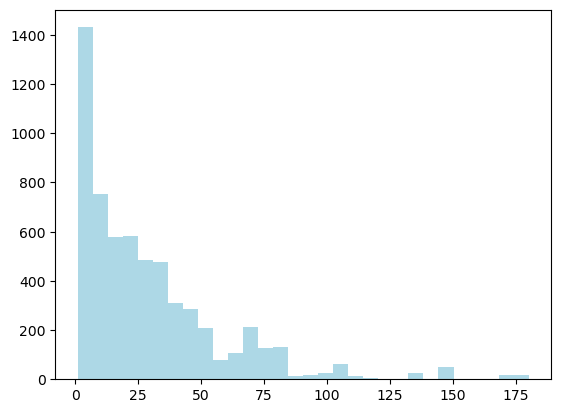

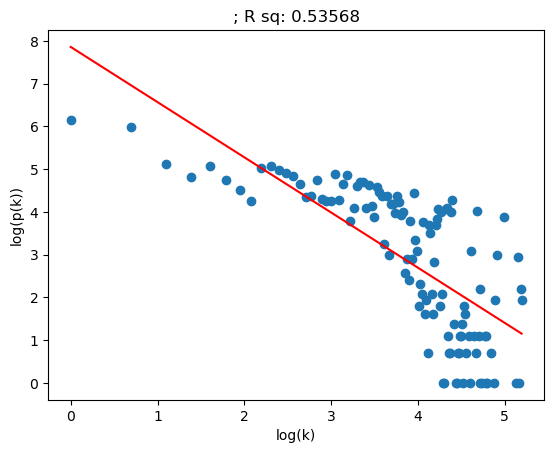

0.5356770449965065

In [18]:
G2= nx.read_graphml('../../data/graphs-2/signed_correlation_network_0.7.graphml')

G2 = cluster_analysis.set_cluster_attributes(G2, '../../pangenome-repo/Pangenome-Analysis-Workflow/codes/Campylobacter_coli')
nx.write_graphml(G2,'../../data/WGCN/TRIAL1_signed_correlation_network_0.7.graphml')

network_analysis.plot_degree_distribution(G2, '')
network_analysis.plot_log_log(G2, '')

In [21]:
get_top_n_nodes(G2, 10, show_product=True)

/home/rayane/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/rayane/miniconda3/lib/python3.12/site-packages/networkx/algorithms/link_analysis/pagerank_alg.py:496: RuntimeWarning: invalid value encountered in subtract
  err = np.absolute(x - xlast).sum()


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')